# ResNet
ResNet quiere decir "Residual  Net" (por que ? lo explico).
Tambien ganadora del ILSVRC (ImageNet). En este caso es de Microsoft (LeNet de Yann Lucun, AlexNet, del grupo de Universidad de Toronto, VGGnet del Visual Geometry Group, Oxford. GoogleNet (Inception) de Googel. La publicacion es de He et. al., 2015 (ver notas de clase, de Microsoft).

La idea es que hasta ese entonces la tendencia era a hacer redes CNN cada vez mas profundas. Pero esto generaba un problema: "vanishinig gradient" o "exploding gradient". Entonces el grupo de Microsoft disenho esta red que cura el problema del "vanishing gradient" o el de "exploding gradient".
En las notas de clase tengo un link a un articulo de George Phillip que da las bases teoricas por las cuales la ResNet cura el problema del "vanishing/exploding" gradient.

Veamos mas la motivacion sobre el nombre ResNet.
Asuma que hasta una capa $\ell$ determinanada el proceso o funcion que simula la red comenzando con unos datos $x$, es
$\mathcal{H}(x)$. El **residuo** entre estos valores $\mathcal{H}(x)$ y los datos de entrada $x$ es

$$ \mathcal{F} = \mathcal{H} - x.$$
La idea es construir $\mathcal{H}$ de forma que se "compense" por este residuo, y entonces

$$\mathcal{H} = \mathcal{F} + x .$$
La pregunta es por que esto ayuda a satisfacer las condiciones para que el gradiente no desvanezca o no se dispare. La clave esta en ese "x". De alguna (no veremos los detalles, los destalles en el articulo de George Phillip que menciono arriba).
El gradiente usa la regla de la cadena, y en algun momento, en esta regla de la cadena aparece el factor $\partial \mathcal{H}/\partial x = I.$
El hacer esa suma de $x$ ayuda a estabilizar el gradiente.

Veamos algunas graficas que nos ayudan a entender esta red.



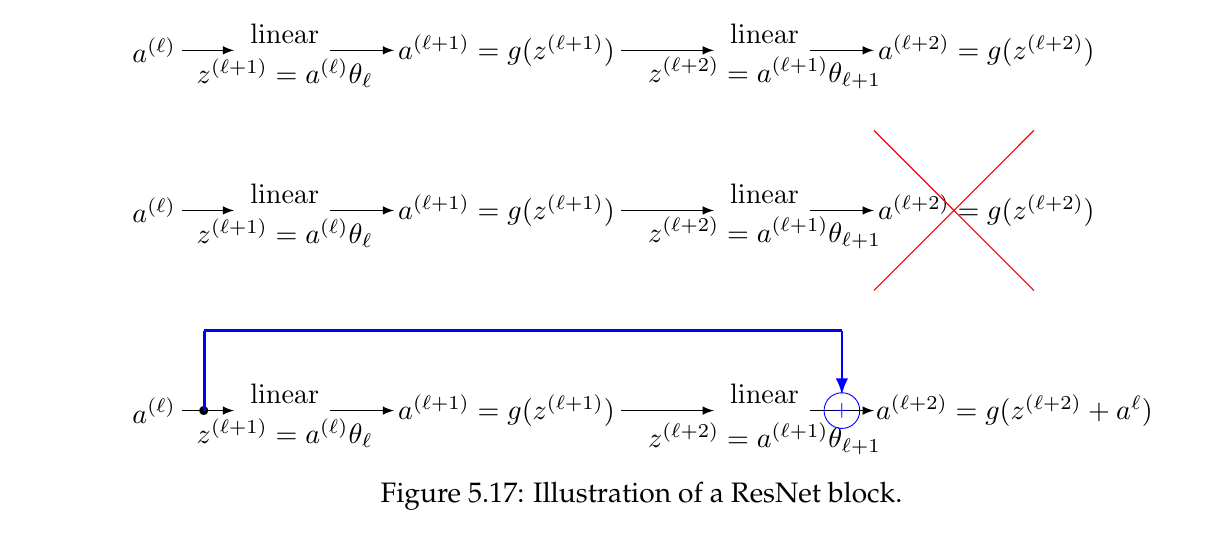

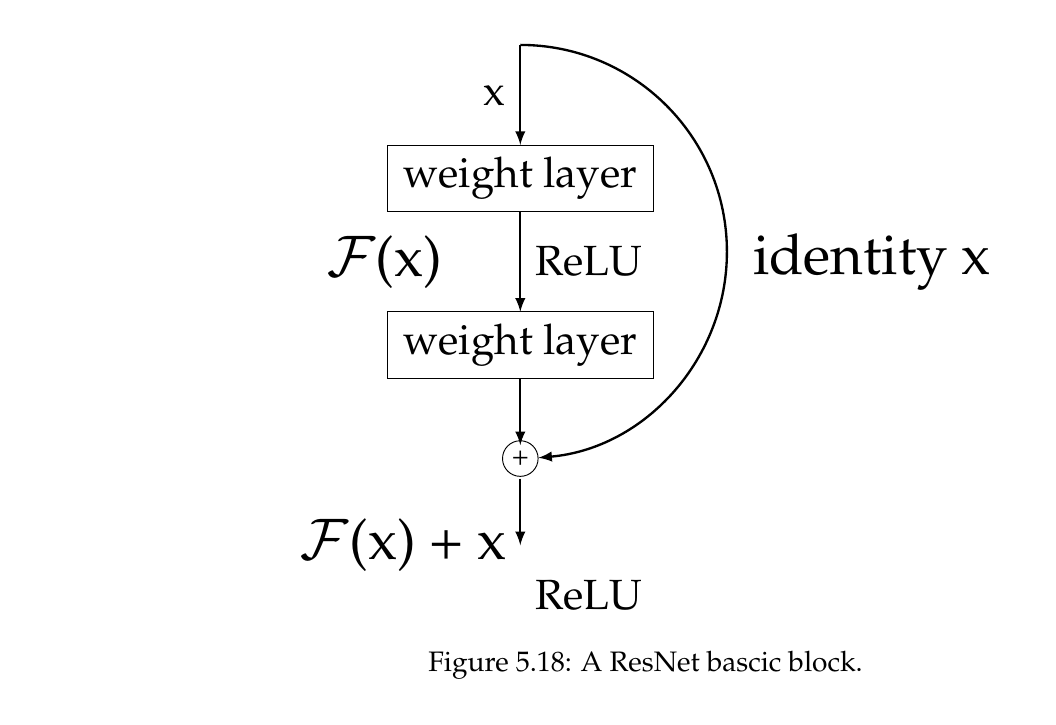

[Josepth Cohen](https://josephpcohen.com/w/wp-content/uploads/resnet-28-small.pdf)  ilustra las redes que hemos estudiado hasta este momento, y en particular la ResNet.

Para la implementacion yo me baso en el trabajo de
[Brownlee](https://machinelearningmastery.com/how-to-implement-major-architecture-innovations-for-convolutional-neural-networks/) muestra implementaciones de las VGG, Inception y la ResNet.



In [ ]:
from keras.models import Model
from keras.layers import Input
from keras.layers import Activation
from keras.layers import Conv2D, MaxPool2D, add
from keras.utils import plot_model


In [ ]:
# definamos el modulo residual
def residual_module(layer_in, n_filters):
    # primera convolucion, con activacion ReLU
    conv1 = Conv2D(n_filters, (3,3), padding='same', activation='relu',
                   kernel_initializer='he_normal')(layer_in)
    # segunda convolucion, sin activacion ReLU
    conv2 = Conv2D(n_filters, (3,3), padding='same', activation='linear',
                   kernel_initializer='he_normal')(conv1)

    # la suma de la entrada con la segunda convolucion
    layer_out=add([conv2, layer_in])

    #Activacion
    layer_out=Activation('relu' )(layer_out)
    return layer_out




In [ ]:
# implementacion
# definimos la entrada
visible = Input(shape=(256, 256, 3))
# agregamos una capa vgg
layer=residual_module(visible, 64)
# create model
model = Model(inputs=visible, outputs=layer)
# sumario del model
model.summary()
# grafica de la arquitectura
plot_model(model,show_shapes=True, to_file="residual_model.png")

ValueError: ignored

filtros en la capa de entrada 3
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 conv2d_3 (Conv2D)           (None, 256, 256, 64)         1792      ['input_2[0][0]']             
                                                                                                  
 conv2d_4 (Conv2D)           (None, 256, 256, 64)         36928     ['conv2d_3[0][0]']            
                                                                                                  
 conv2d_2 (Conv2D)           (None, 256, 256, 64)         256       ['input_2[0][0]']             
                                                              

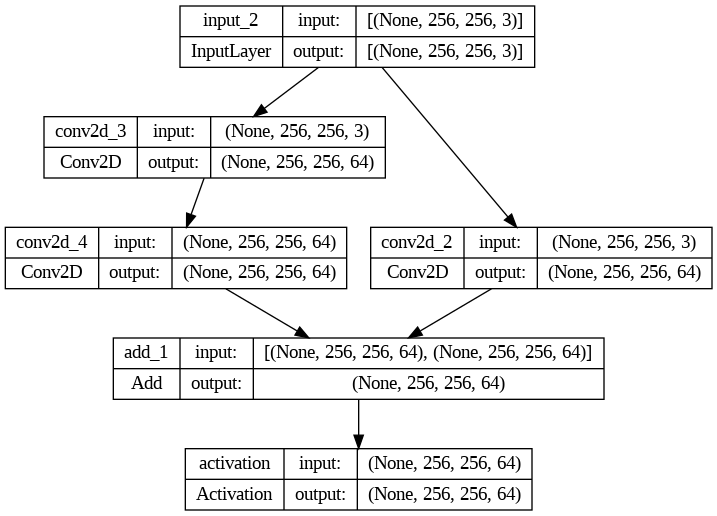

In [ ]:
# definamos el modulo residual,
# lo hacemos mas robusto para el caso en que la profundidad (z) de las capas
# sea incompatible
def residual_module(layer_in, n_filters):
    # primera convolucion, con activacion ReLU
    merge_input = layer_in

    # verificamos que pasa si las profundidades (numeros de filtros)
    # no coinciden
    if layer_in.shape[-1] != n_filters:
        merge_input =  Conv2D(n_filters, (1,1), padding='same', activation='relu',
                   kernel_initializer='he_normal')(layer_in)
        print(f"filtros en la capa de entrada {layer_in.shape[-1]}")
    # segunda convolucion, sin activacion ReLU
    conv1 = Conv2D(n_filters, (3,3), padding='same', activation='linear',
                   kernel_initializer='he_normal')(layer_in)

    conv2 = Conv2D(n_filters, (3,3), padding='same', activation='linear',
                   kernel_initializer='he_normal')(conv1)

    # la suma de la entrada con la segunda convolucion
    layer_out=add([conv2, merge_input])

    #Activacion
    layer_out=Activation('relu' )(layer_out)
    return layer_out


# implementacion
# definimos la entrada
visible = Input(shape=(256, 256, 3))
# agregamos una capa vgg
layer=residual_module(visible, 64)
# create model
model = Model(inputs=visible, outputs=layer)
# sumario del model
model.summary()
# grafica de la arquitectura
plot_model(model,show_shapes=True, to_file="residual_model.png")



# Recurrent Neural Networks (RNN).
Redes neuronales recurrentes. Este tipo de redes se usan para secuencias. Ejemplos, el texto que usted entre en su WhatsApp.
Al final del curso veremos NLP: Natural Language Processing el cual depende estas redes. Una red en particular que veremos proximamente y es del tipo RNN es la LSTM: Long Short Term Memory.

Para motivar estas redes voy a introducir un ejemplo simple.
Este ejemplo esta basado en un vide en YouTube de
[Luis Serrano](https://www.youtube.com/watch?v=UNmqTiOnRfg).

Mientras Luis Serrano lo hace con la comida del proxima dia, yo lo hago con tres lugares que se deben visitar $A,B,C$. Piense en un empleado de una companhia que le tocas viajar entre las ciudades $A$, $B$ y $C$ (por ejemplo Armenia, Bogota, Cali).
En ese orden. Queremos construir una red que nos genere este modelo. Inicialmente definimos "one-hot-encoding" vectors.


$$ A \mapsto \begin{pmatrix} 1 \\ 0 \\ 0 \end{pmatrix}
\quad ,  \quad  B \mapsto \begin{pmatrix} 0 \\ 1 \\ 0 \end{pmatrix}  
\quad ,  \quad  C \mapsto \begin{pmatrix} 0 \\ 0 \\ 1 \end{pmatrix}  
$$



El modelo matematico (de redes neuronales) que me resuelve el problema de mandar $A$ a $B$, $B$ a $C$ y $C$ a $A$ es

$$
M=
\begin{pmatrix}
0 & 0 & 1 \\
1 & 0 & 0 \\
0 & 1 & 0 \\
\end{pmatrix}
.
$$
Veamos por que este modelo $M$ funciona.


$$
MA = \begin{pmatrix}
0 & 0 & 1 \\
1 & 0 & 0 \\
0 & 1 & 0 \\
\end{pmatrix}
\begin{pmatrix}
1 \\ 0 \\ 0
\end{pmatrix}
= \begin{pmatrix} 0 \\ 1 \\ 0  \end{pmatrix} = B
.$$

$$
MB = \begin{pmatrix}
0 & 0 & 1 \\
1 & 0 & 0 \\
0 & 1 & 0 \\
\end{pmatrix}
\begin{pmatrix}
0 \\ 1 \\ 0
\end{pmatrix}
= \begin{pmatrix} 0 \\ 0 \\ 1  \end{pmatrix} = C
.$$

$$
MC = \begin{pmatrix}
0 & 0 & 1 \\
1 & 0 & 0 \\
0 & 1 & 0 \\
\end{pmatrix}
\begin{pmatrix}
0 \\ 0 \\ 1
\end{pmatrix}
= \begin{pmatrix} 1 \\ 0 \\ 0  \end{pmatrix} = A
.$$






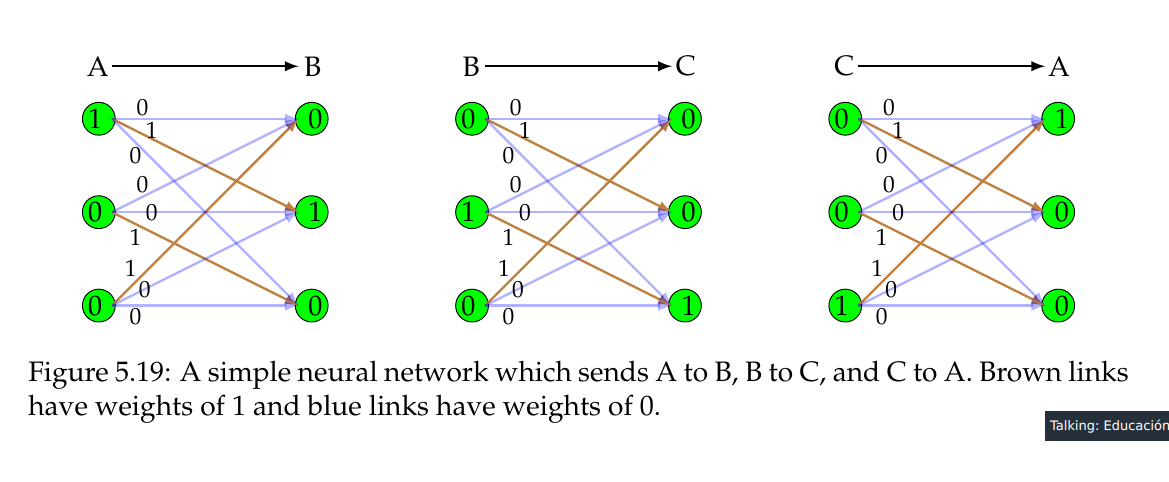

Mas en abstracto esta red simulada por el experimento de la figura anterior se resume en:

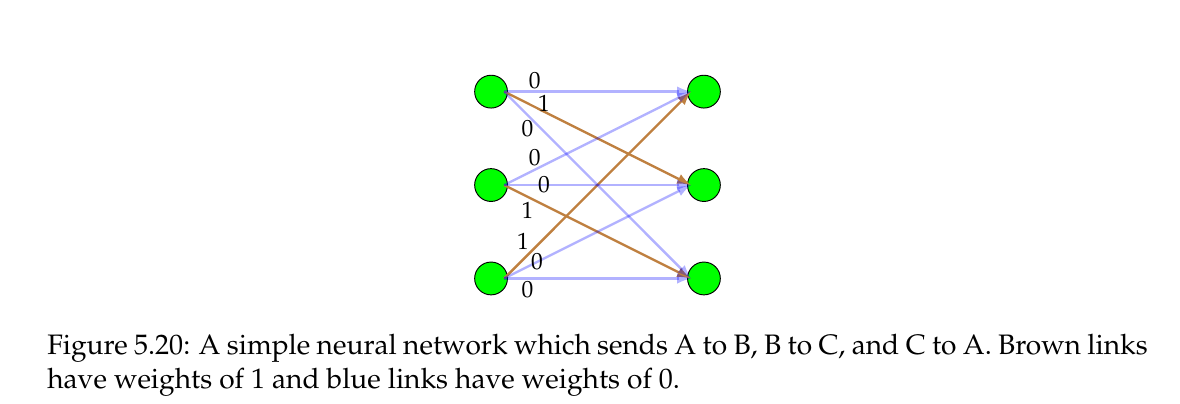


Que pasa si queremos tener la secuencia "ABCABCABCABCABCA ..."

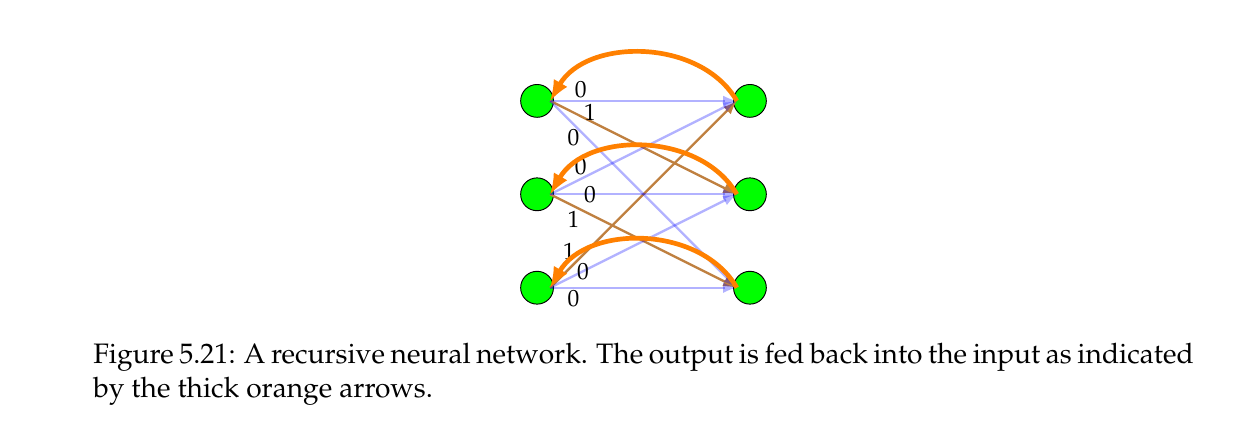

Compliquemos el modelo un poco mas. Asumamos que el mensajero le puede tocar quedarse a dormir en alguna de las ciudades.
Algo como $ABCCABCAA$ (que pueda repetir letra).

En este caso tenemos dos posibilidades:

* se queda
$$ \text{stay} \mapsto \binom{1}{0}.$$
$$ \text{leave} \mapsto \binom{0}{1}.$$

El modelo $M$ se complica un poco mas. Escribamos la matriz, extendida $M$ como


\begin{eqnarray}
M =
\begin{pmatrix}
1 & 0 & 0  \\
0 & 1 & 0  \\
0 & 0 & 1  \\
-- & -- & -- \\
0 & 0 & 1  \\
1 & 0 & 0  \\
0 & 1 & 0  \\
\end{pmatrix}
\end{eqnarray}

Vamos a ver como funciona este modelo. Asumamos que llegamos a Cali ($C$) y nos queremos queda ahir


\begin{eqnarray}
MC =
\begin{pmatrix}
1 & 0 & 0  \\
0 & 1 & 0  \\
0 & 0 & 1  \\
-- & -- & -- \\
0 & 0 & 1  \\
1 & 0 & 0  \\
0 & 1 & 0  \\
\end{pmatrix}
\begin{pmatrix}
0 \\ 0 \\ 1
\end{pmatrix}
=
\begin{pmatrix}
0 \\ 0 \\ 1  \\ -- \\ 1 \\ 0 \\ 0
\end{pmatrix}
\end{eqnarray}

En este modelo, si escoge la parte de arriba se queda en Cali o si escoje la de abajo, avanza a Armenia.


Vamos a construir la "stay-leave" matrix
Esta esta dada por


\begin{eqnarray}
\text{stay-leave} = \begin{pmatrix}
1 & 0 \\
1 & 0 \\
1 & 0 \\
-- & --  \\
0 & 1 \\
0 & 1 \\
0 & 1
\end{pmatrix}
\end{eqnarray}

Veamos como esta matriz opera en quedarse (stay) or irse (leave).


\begin{eqnarray}
\text{ ( stay-leave)(stay) }=
\begin{pmatrix}
1 & 0 \\
1 & 0 \\
1 & 0 \\
-- & --  \\
0 & 1 \\
0 & 1 \\
0 & 1
\end{pmatrix}
\binom{1}{0}
= \begin{pmatrix}
1 \\ 1 \\ 1 \\ -- \\
0 \\ 0 \\ 0
\end{pmatrix}
\end{eqnarray}




\begin{eqnarray}
\text{ ( stay-leave)(leave) }=
\begin{pmatrix}
1 & 0 \\
1 & 0 \\
1 & 0 \\
-- & --  \\
0 & 1 \\
0 & 1 \\
0 & 1
\end{pmatrix}
\binom{0}{1}
= \begin{pmatrix}
0 \\ 0 \\ 0 \\ -- \\
1 \\ 1 \\ 1
\end{pmatrix}
\end{eqnarray}


# continuamos en la proxima clase